# Application of design best practices to COVID-19 dataset 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import scvi
import shutil

from oor_benchmark.methods.scArches_milo import run_milo

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

Global seed set to 0


In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/COVID_analysis/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir


In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [9]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [10]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

## Latent embedding workflow

(Running on cluster)

Train reference scVI models

Map query datasets with scArches

## Parse outputs into alternative reference designs

In [11]:
data_dir = outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID_full/'

In [7]:
# adata_atlas = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.atlas.h5ad')
# adata_covid = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.covid.h5ad')
# adata_ctrl = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.ctrl.h5ad')
# adata_dict = {'A': adata_atlas, 'P': adata_covid, 'C': adata_ctrl}

# def _read_design(model_query_dir, n_neighbors=100):
#     ref_string = model_query_dir.split('ref')[-1]
#     query_string = model_query_dir.split('_ref')[0].split('_')[-1]
#     model_reference_dir = f'model_reference_{ref_string}'

#     # Make merged anndata object
#     print("Merging anndatas...\n")
#     adata_design = anndata.concat([adata_dict[d] for d in ref_string] + [adata_dict[d] for d in query_string],
#         label='dataset_group',
#         keys = [d for d in ref_string] + [d for d in query_string]
#         )

#     print("Loading trained models...\n")
#     try:
#         vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
#     except:
#         scvi.model.SCVI.convert_legacy_save(outdir + model_reference_dir, outdir + model_reference_dir + f'_scvi{scvi.__version__}', overwrite=True)
#         shutil.copyfile(outdir + model_reference_dir + '/adata.h5ad', outdir + model_reference_dir + f'_scvi{scvi.__version__}/adata.h5ad')
#         vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
#     try:
#         vae_query = scvi.model.SCVI.load( outdir + model_query_dir + f'_scvi{scvi.__version__}')
#     except:
#         scvi.model.SCVI.convert_legacy_save(outdir + model_query_dir, outdir + model_query_dir + f'_scvi{scvi.__version__}', overwrite=True)
#         shutil.copyfile(outdir + model_query_dir + '/adata.h5ad', outdir + model_query_dir + f'_scvi{scvi.__version__}/adata.h5ad')
#         vae_query = scvi.model.SCVI.load( outdir + model_query_dir + f'_scvi{scvi.__version__}')

#     model_obs_names = vae_reference.adata.obs_names.tolist() + vae_query.adata.obs_names.tolist()
#     if all(model_obs_names == adata_design.obs_names):
#         adata_design.obsm['X_scVI'] = np.vstack([
#             vae_reference.get_latent_representation(),
#             vae_query.get_latent_representation(),
#             ])
#     else:
#         raise ValueError("Cell names don't match order in model")

#     ## Remove atlas, if present
#     adata_design = adata_design[adata_design.obs['dataset_group'] != 'A'].copy()

#     ## Compute KNN graph
#     print("Computing KNN graph...\n")
#     sc.pp.neighbors(adata_design, use_rep='X_scVI', n_neighbors=n_neighbors)

#     ## Run UMAP
#     print("Running UMAP...\n")
#     sc.tl.umap(adata_design)

#     ## Save 
#     file_name = f"PBMC_COVID.subsample500cells.design.{model_query_dir.split('model_')[-1]}.h5ad"
#     print(f"Saving to {file_name}...\n")
#     adata_design.write_h5ad(outdir + file_name)

# def _read_design_scvi(model_reference_dir, n_neighbors=100):
#     ref_string = model_reference_dir.split('_')[-1]
#     model_reference_dir = f'model_reference_{ref_string}'

#     # Make merged anndata object
#     print("Merging anndatas...\n")
#     adata_design = anndata.concat([adata_dict[d] for d in ref_string],
#         label='dataset_group',
#         keys = [d for d in ref_string]
#         )

#     print("Loading trained models...\n")
#     try:
#         vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
#     except:
#         scvi.model.SCVI.convert_legacy_save(outdir + model_reference_dir, outdir + model_reference_dir + f'_scvi{scvi.__version__}', overwrite=True)
#         shutil.copyfile(outdir + model_reference_dir + '/adata.h5ad', outdir + model_reference_dir + f'_scvi{scvi.__version__}/adata.h5ad')
#         vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    
#     model_obs_names = vae_reference.adata.obs_names.tolist() 
#     if all(model_obs_names == adata_design.obs_names):
#         adata_design.obsm['X_scVI'] = vae_reference.get_latent_representation()
#     else:
#         raise ValueError("Cell names don't match order in model")

#     ## Remove atlas, if present
#     adata_design = adata_design[adata_design.obs['dataset_group'] != 'A'].copy()

#     ## Compute KNN graph
#     print("Computing KNN graph...\n")
#     sc.pp.neighbors(adata_design, use_rep='X_scVI', n_neighbors=n_neighbors)

#     ## Run UMAP
#     print("Running UMAP...\n")
#     sc.tl.umap(adata_design)

#     ## Save 
#     file_name = f"PBMC_COVID.subsample500cells.design.{model_reference_dir.split('model_reference')[-1]}.h5ad"
#     print(f"Saving to {file_name}...\n")
#     adata_design.write_h5ad(outdir + file_name)


In [12]:
# for mq in [x for x in os.listdir(outdir) if x.startswith('model_query_') and 'scvi' not in x]:
#     _read_design(mq)

# for mq in ['model_reference_PC', 'model_reference_PAC']:
#     _read_design_scvi(mq)


## Milo analysis

In [13]:
## Load dataset specific obs
query_batch = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/10_1038_s41591_021_01329_2.h5ad'
stephenson_obs = sc.read_h5ad(query_batch, backed='r').obs.copy()

### Prepare ACR design object

In [23]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID_full/'
import scanpy as sc
adata = sc.read_h5ad(data_dir + 'PBMC_COVID.full.ACRdesign_scArches.h5ad', backed=True)

ValueError: Shape of passed values is (599045, 27), indices imply (27, 27)

In [21]:
adata.var_names

Index(['ENSG00000243485', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000229905', 'ENSG00000177757',
       'ENSG00000225880', 'ENSG00000230368', 'ENSG00000230699',
       'ENSG00000187634',
       ...
       'ENSG00000274847', 'ENSG00000276256', 'ENSG00000273748',
       'ENSG00000276017', 'ENSG00000278817', 'ENSG00000277196',
       'ENSG00000278384', 'ENSG00000277856', 'ENSG00000275063',
       'ENSG00000271254'],
      dtype='object', name='feature_id', length=24727)

In [20]:
nhood_adata = sc.read_h5ad(data_dir + 'PBMC_COVID.full.ACRdesign_scArches.nhood_adata.h5ad')

In [17]:
os.path.exists(data_dir + 'PBMC_COVID.full.ACRdesign_scArches.nhood_adata.h5ad')

True

In [15]:
## Add dataset specific obs 
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata.obs_names]]
new_obs.index = adata.obs_names
adata.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata.obs.columns)], adata.obs], 1)

## Add interferon signature 
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

adata.var = adata_atlas.var.loc[adata.var_names]
adata.var_names = adata.var['gene_name'].values
## Taken from https://www.nature.com/articles/s41586-021-04345-x
ifn_signature_genes = [
    'BST2', 'CMPK2', 'EIF2AK2', 'EPSTI1', 'HERC5', 'IFI35', 'IFI44L', 'IFI6', 
    'IFIT3', 'ISG15', 'LY6E', 'MX1', 'MX2', 'OAS1', 'OAS2', 'PARP9', 'PLSCR1', 
    'SAMD9', 'SAMD9L', 'SP110', 'STAT1', 'TRIM22', 'UBE2L6', 'XAF1', 'IRF7'
    ]

sc.tl.score_genes(adata, ifn_signature_genes, score_name='IFN_signature')

KeyError: 'No nhood_adata_file associated to adata'

### Prepare CR design object

In [13]:
adata_c = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_P_refC.h5ad')
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_c.obs_names]]
new_obs.index = adata_c.obs_names
adata_c.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_c.obs.columns)], adata_c.obs], 1)
adata_c.obs['IFN_signature'] = adata.obs.loc[adata_c.obs_names, 'IFN_signature']

adata_c.layers['counts'] = adata_c.X.copy()
sc.pp.normalize_per_cell(adata_c)
sc.pp.log1p(adata_c)

/tmp/ipykernel_51793/2344013108.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  adata_c.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_c.obs.columns)], adata_c.obs], 1)


### Run differential analysis

In [14]:
run_milo(adata, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods_continuous(adata, "IFN_signature")
milopy.utils.annotate_nhoods(adata, 'author_cell_type')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/vectors.py:1010: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:2178: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.ht

In [15]:
run_milo(adata_c, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')
milopy.utils.annotate_nhoods_continuous(adata_c, "IFN_signature")

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


### Add broad annotation labels

In [16]:
anno_labels = adata.obs['author_cell_type'].unique()
anno_groups = {}
anno_groups['B_cell'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('B_')]
anno_groups['HSPC'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('HSC_')]
anno_groups['CD14_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD14_mono' in x]
anno_groups['CD16_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD16_mono' in x]
anno_groups['CD4_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD4.")]
anno_groups['CD8_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD8.")]
anno_groups['ILC'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("ILC")]
anno_groups['Plasma_cell'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("Plasma_cell")]

for x in anno_labels: 
    if x not in sum(anno_groups.values(), []):
        anno_groups[x] = [x]

anno_labels_dict = {x:k for k,v in anno_groups.items() for x in v}

adata.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata.obs['author_cell_type']]
adata_c.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_c.obs['author_cell_type']]


### Quality control

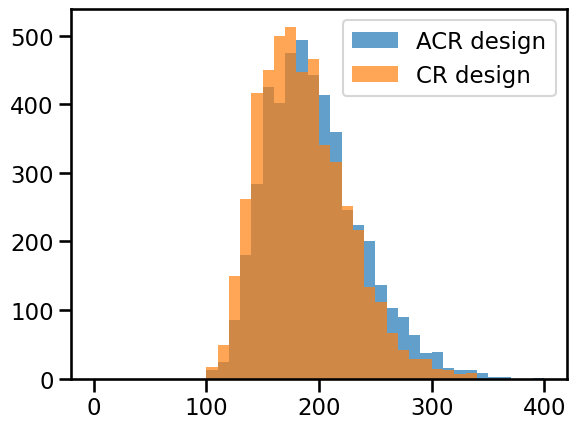

In [21]:
binwidth=10
plt.hist(np.array(adata.obsm['nhoods'].sum(0)).flatten(),
        bins=np.arange(0, 400 + binwidth, binwidth), 
         alpha=0.7, label='ACR design'
        );
plt.hist(np.array(adata_c.obsm['nhoods'].sum(0)).flatten(),
                 bins=np.arange(0, 400 + binwidth, binwidth), 
         alpha=0.7, label='CR design'
        );
plt.legend()

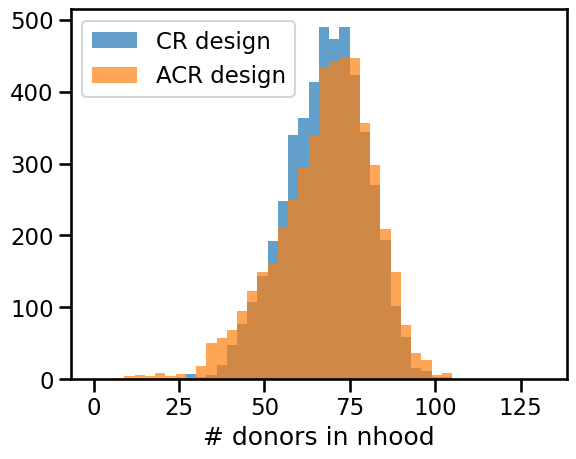

In [18]:
binwidth=3
nhood_adata = adata_c.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design'
        );

nhood_adata = adata.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='ACR design'
        );
plt.legend()
plt.xlabel('# donors in nhood');
plt.show()

## Integration plots

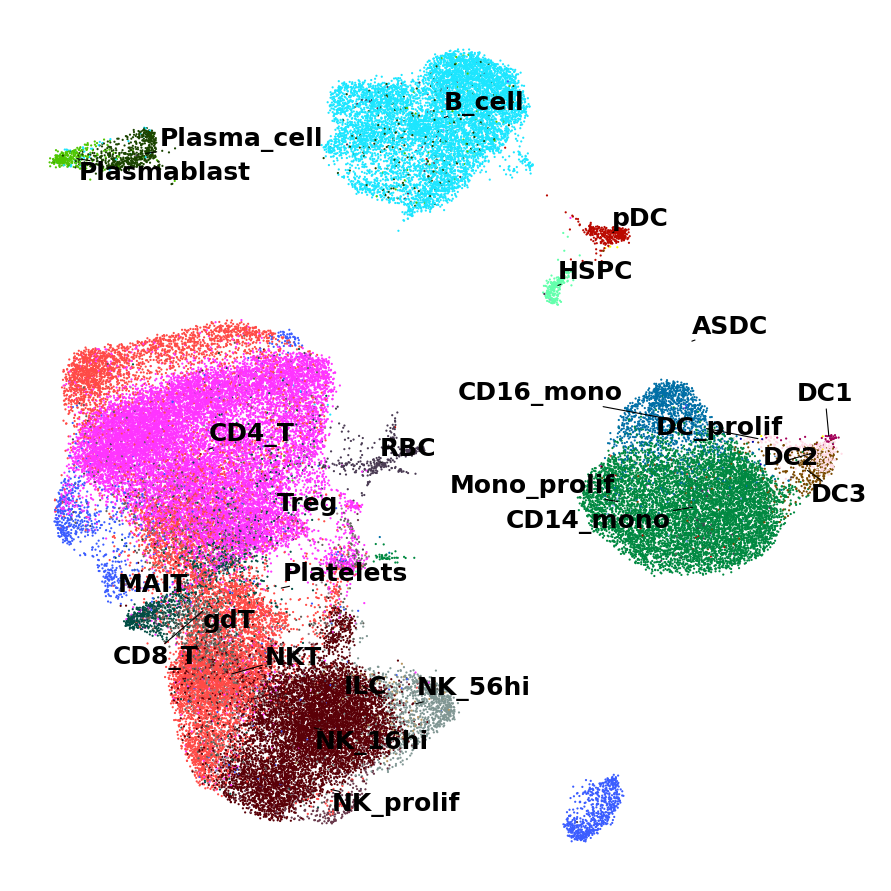

In [25]:
with rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(adata, color=['author_cell_type_broad'], size=10, palette=sc.pl.palettes.godsnot_102,
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    gen_mpl_labels(
        adata,
        "author_cell_type_broad",
    #     exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold'),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + "PAC_design_celltypes.png")

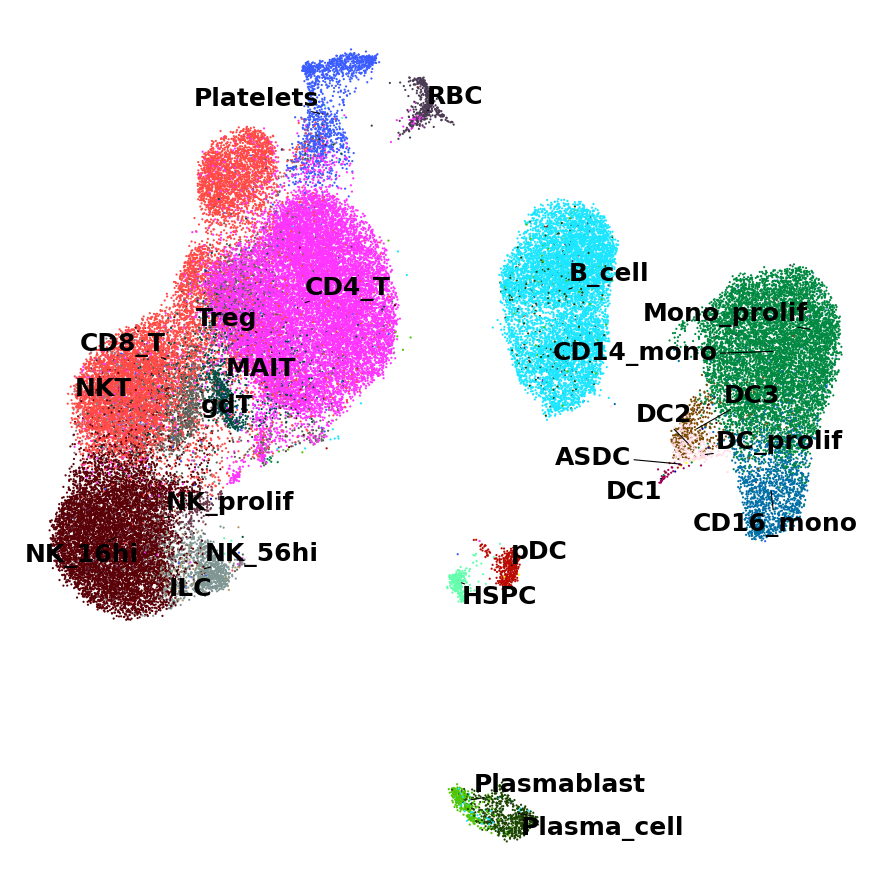

In [29]:
with rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(adata_c, color=['author_cell_type_broad'], size=10, palette=sc.pl.palettes.godsnot_102,
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    gen_mpl_labels(
        adata_c,
        "author_cell_type_broad",
    #     exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold'),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + "PC_design_celltypes.png")

In [35]:
pc_donors = adata_c.obs.donor_id.unique()
pac_donors = adata.obs.donor_id.unique()
len(pac_donors)
len(pc_donors)

119

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


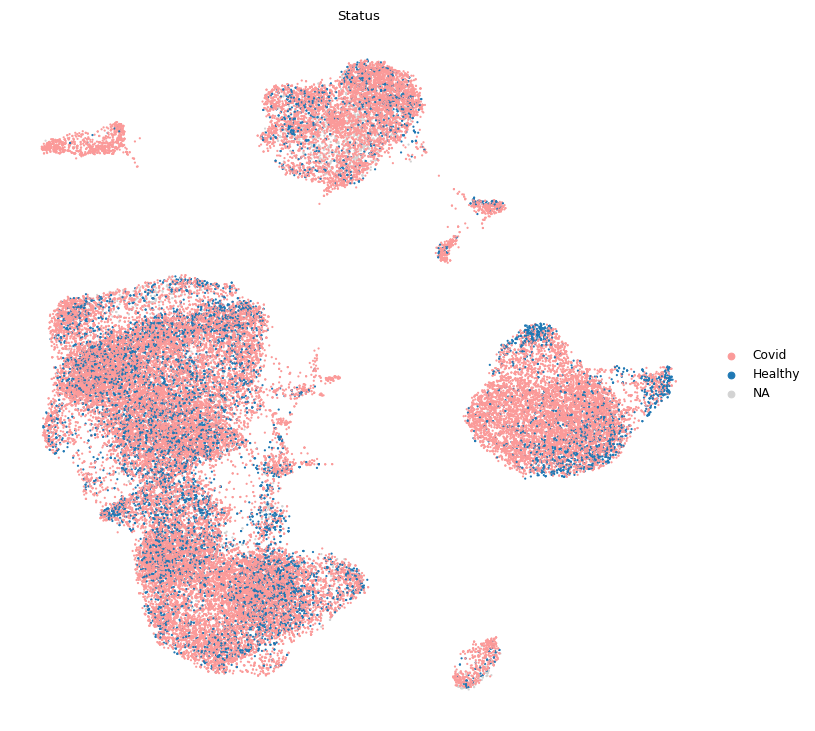

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


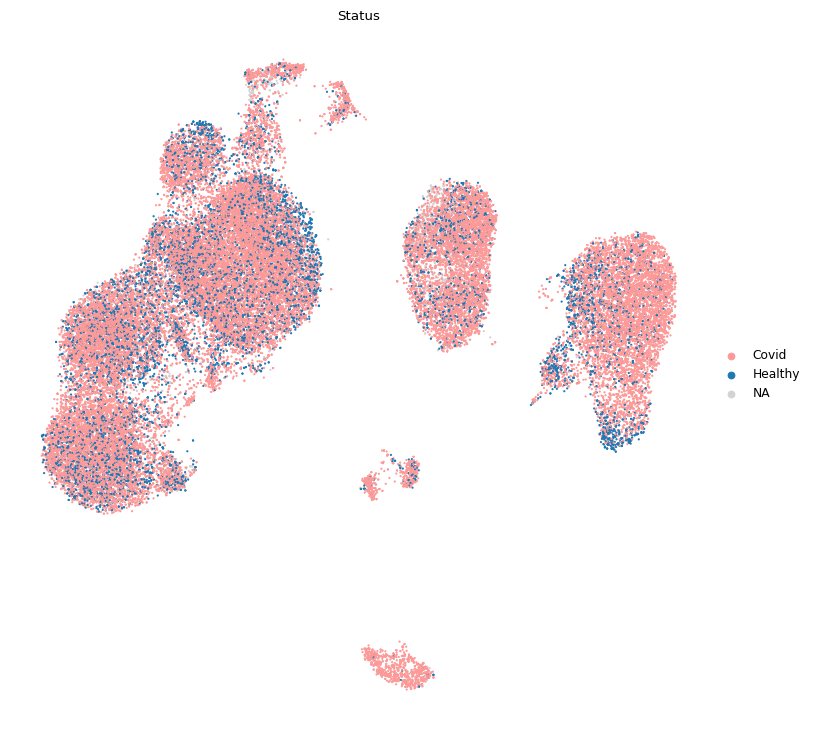

In [42]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f', 'Non_covid':'#fdbf6f'}

with rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(adata[np.random.choice(adata.obs_names, adata.n_obs)], color=['Status'], 
               legend_loc='right margin', frameon=False, groups=['Covid', 'Healthy'],
               size=10, palette=covid_palette,
              save='PAC_covid_status.png');
    sc.pl.umap(adata_c[np.random.choice(adata_c.obs_names, adata_c.n_obs)], color=['Status'], 
               legend_loc='right margin', frameon=False, groups=['Covid', 'Healthy'],
               size=10, palette=covid_palette,
              save='PC_covid_status.png');


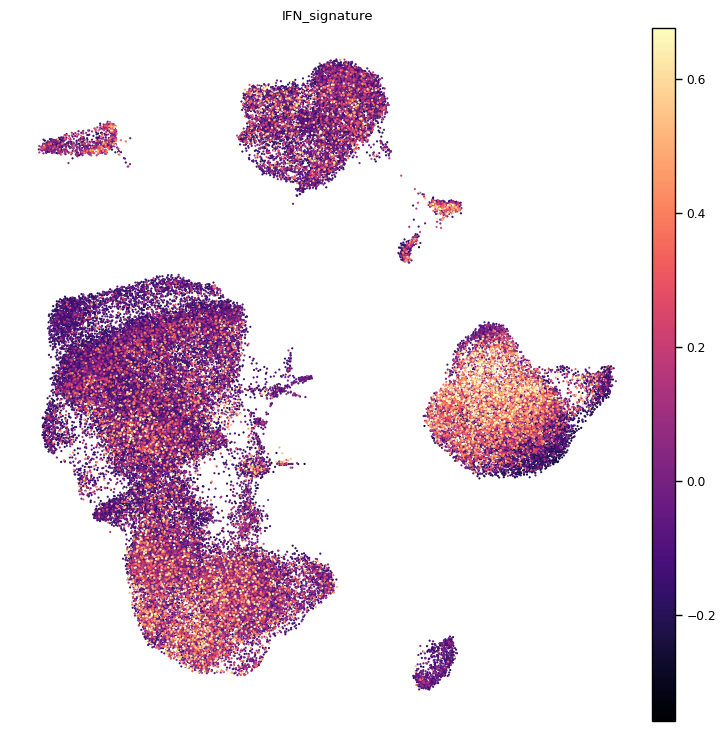

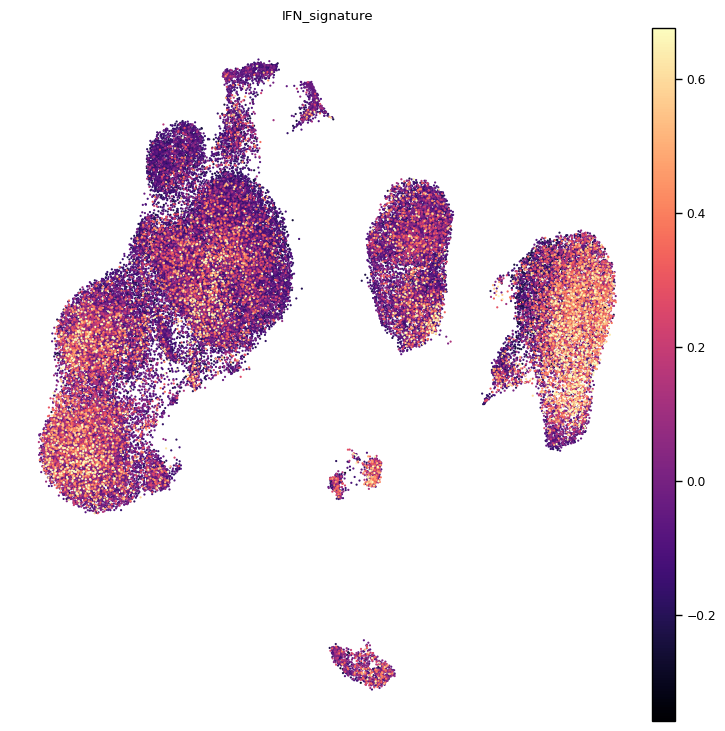

In [47]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f'}
with rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(adata, color=['IFN_signature'], 
               legend_loc='right margin', frameon=False, 
               size=10, cmap = 'magma', vmax=np.quantile(adata.obs['IFN_signature'], 0.99),
              save='PAC_IFN_status.png');
    sc.pl.umap(adata_c, color=['IFN_signature'], 
               legend_loc='right margin', frameon=False, 
               size=10, cmap = 'magma', vmax=np.quantile(adata.obs['IFN_signature'], 0.99),
              save='PC_IFN_status.png');


In [57]:
adata.obs.donor_id.unique()

(119,)

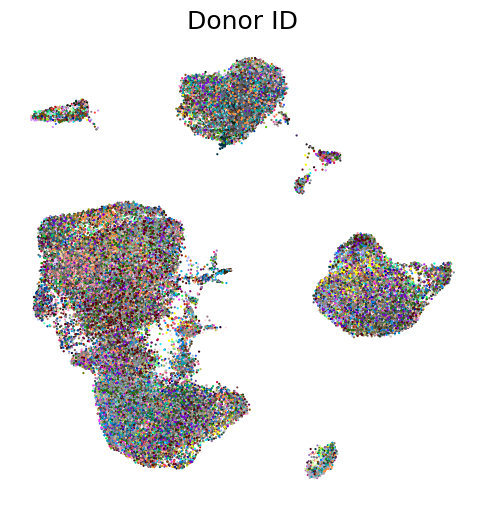

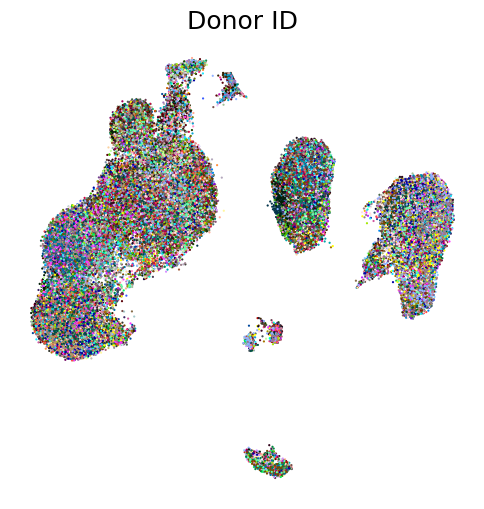

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


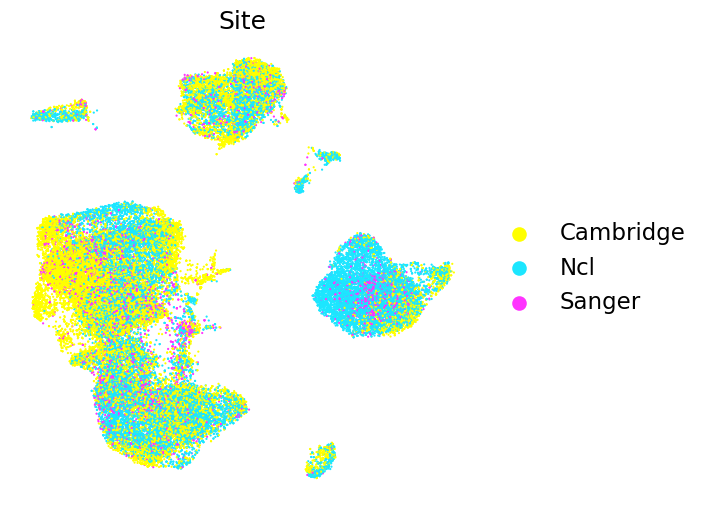

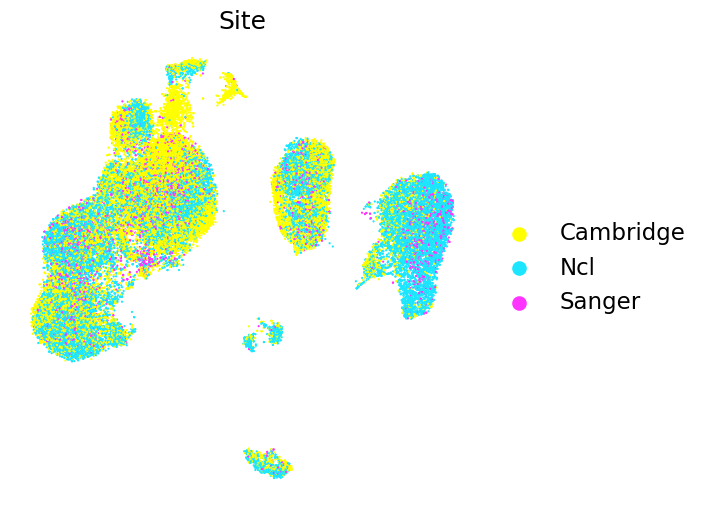

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


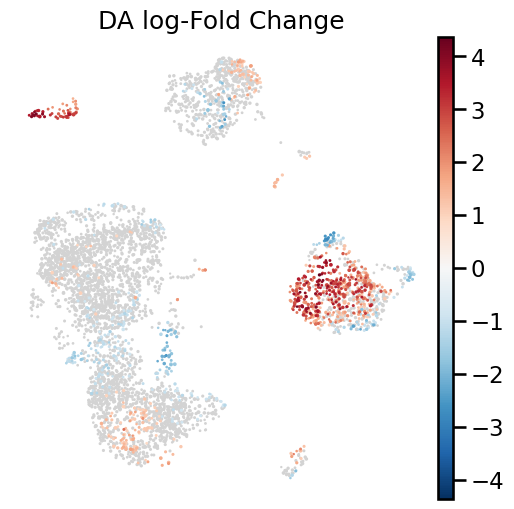

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


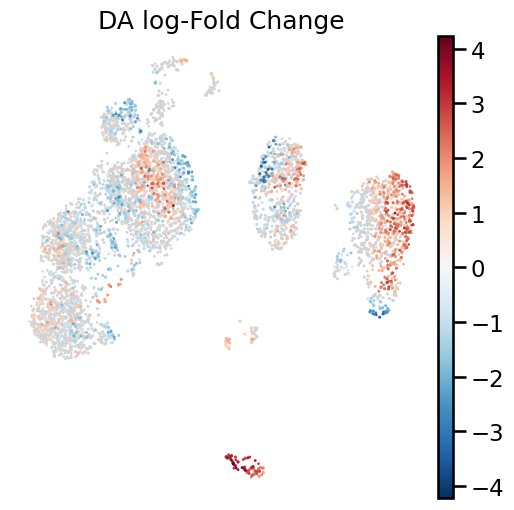

In [58]:
## Supplementary figure
milopy.utils.build_nhood_graph(adata)
milopy.utils.build_nhood_graph(adata_c)
# del adata.uns['donor_id_colors'] 
sns.set_context('talk')
with rc_context({'figure.figsize':[6,6]}):
#     sc.pl.umap(adata, color=['total_counts'], legend_loc='right margin', size=30, palette=sc.pl.palettes.godsnot_102, groups=['Platelets'], vmax=6000);
    sc.pl.umap(adata, color=['donor_id'], legend_loc='none', size=10, frameon=False, title = "Donor ID", save='PAC_donor.png');
    sc.pl.umap(adata_c, color=['donor_id'], legend_loc='none', size=10, frameon=False, title = "Donor ID", save='PC_donor.png');
    sc.pl.umap(adata[np.random.choice(adata.obs_names, adata.n_obs)], color=['Site'], legend_loc='right margin', 
               size=10, palette=sc.pl.palettes.godsnot_102, frameon=False, title = "Site", save='PAC_site.png');
    sc.pl.umap(adata_c[np.random.choice(adata_c.obs_names, adata.n_obs)], color=['Site'], legend_loc='right margin', 
               size=10, palette=sc.pl.palettes.godsnot_102, frameon=False, title = "Site", save='PC_site.png');
    milopy.plot.plot_nhood_graph(adata, min_size=0.1, save='PAC_miloDA.png')
    milopy.plot.plot_nhood_graph(adata_c, min_size=0.1, save='PC_miloDA.png')

In [72]:

print(f"# donors Atlas: {adata_atlas.obs.donor_id.unique().shape[0]}")
print(f"# donors COVID: {adata[adata.obs['Status'] == 'Covid'].obs.donor_id.unique().shape[0]}")
print(f"# donors ctrl: {adata[adata.obs['Status'] == 'Healthy'].obs.donor_id.unique().shape[0]}")

print(f"# studies Atlas: {adata_atlas.obs.dataset_id.unique().shape[0]}")

# donors Atlas: 1219
# donors COVID: 90
# donors ctrl: 23
# studies Atlas: 12


## Plot IFN state recovery

In [18]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type_broad')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type_broad')

In [19]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata_c = adata_c.uns['nhood_adata'].copy()

pl_cell_types = nhood_adata.obs['nhood_annotation'].value_counts().index
pl_cell_types = pl_cell_types[pl_cell_types != 'nan']

df1 = nhood_adata.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df1['design'] = 'ACR'
df2 = nhood_adata_c.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df2['design'] = 'CR'
pl_df = pd.concat([df1,df2])

/tmp/ipykernel_16683/3704143388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['design'] = 'ACR'
/tmp/ipykernel_16683/3704143388.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['design'] = 'CR'


In [20]:
%%R -i pl_df
head(pl_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  nhood_IFN_signature      logFC  SpatialFDR nhood_annotation design
1         -0.00220008 -0.2194488 0.773792012          NK_16hi    ACR
2         -0.06581493 -0.5853851 0.271597767            CD8_T    ACR
3         -0.07545920 -0.2437837 0.751638382           B_cell    ACR
4         -0.06753626  0.2168581 0.777359813            CD4_T    ACR
5         -0.14077664 -0.2466057 0.766543201            CD4_T    ACR
6         -0.02367600 -1.4926319 0.005747825            CD4_T    ACR


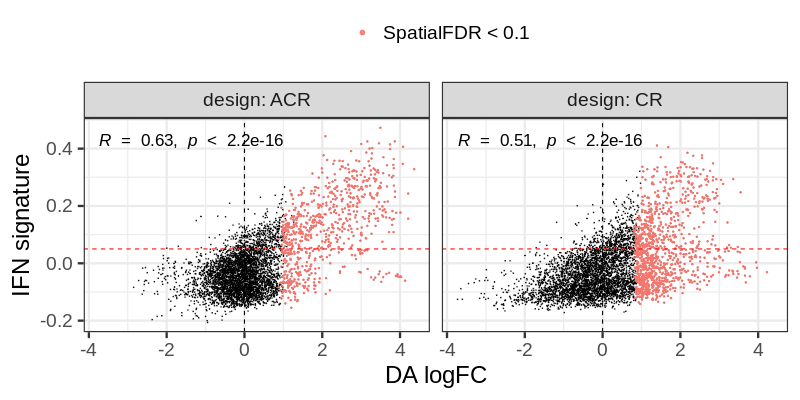

In [22]:
%%R -w 800 -h 400 -i figdir
pl_df %>%
    group_by(nhood_annotation, design) %>%
    ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
    geom_point(size=0.2, alpha=0.7) +
    geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9) +
    facet_wrap(design~., labeller='label_both') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    geom_vline(xintercept=0, linetype=2) +
    geom_hline(yintercept=0.05, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggpubr::stat_cor(size=6) +
    ggsave(paste0(figdir, 'IFNVSlogFC_all_ggplot.png'), width=12, height=6) +
    ggsave(paste0(figdir, 'IFNVSlogFC_all_ggplot.pdf'), width=12, height=6)

In [28]:
%%R
install.packages('cocor')
library(cocor)

* installing *source* package ‘cocor’ ...
** package ‘cocor’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (cocor)


In [47]:
%%R
cocor_res <- cocor(formula = ~ logFC + nhood_IFN_signature | logFC + nhood_IFN_signature, 
      data = split(pl_df, pl_df$design))
cocor_res


  Results of a comparison of two correlations based on independent groups

Comparison between r1.jk (logFC, nhood_IFN_signature) = 0.6346 and r2.hm (logFC, nhood_IFN_signature) = 0.5097
Difference: r1.jk - r2.hm = 0.1249
Data: ACR: j = logFC, k = nhood_IFN_signature; CR: h = logFC, m = nhood_IFN_signature
Group sizes: n1 = 4789, n2 = 4846
Null hypothesis: r1.jk is equal to r2.hm
Alternative hypothesis: r1.jk is not equal to r2.hm (two-sided)
Alpha: 0.05

fisher1925: Fisher's z (1925)
  z = 9.1608, p-value = 0.0000
  Null hypothesis rejected

zou2007: Zou's (2007) confidence interval
  95% confidence interval for r1.jk - r2.hm: 0.0981 0.1518
  Null hypothesis rejected (Interval does not include 0)



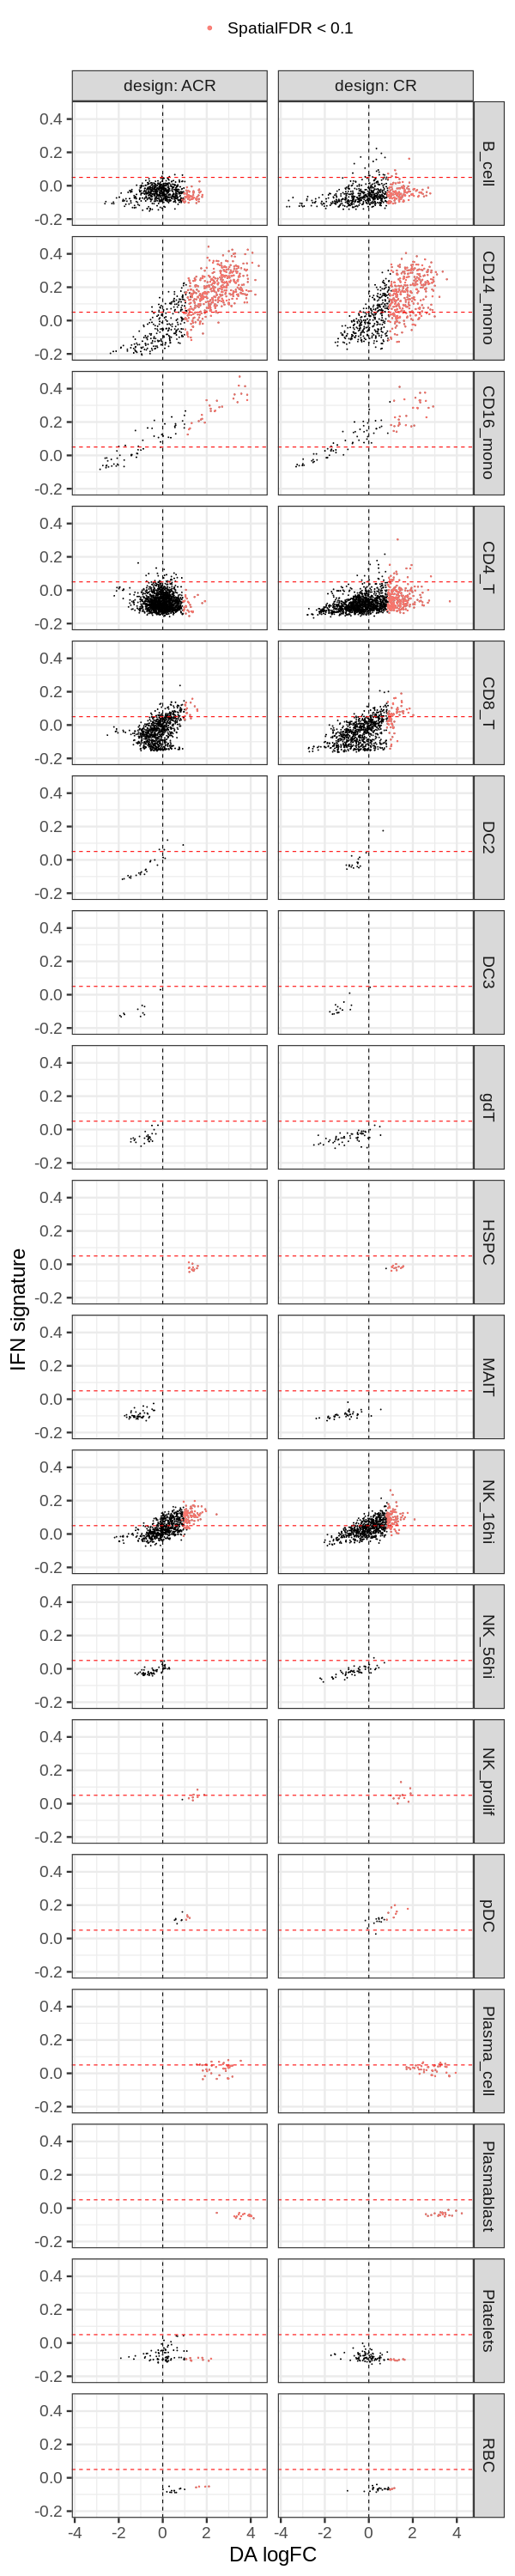

In [94]:
%%R -w 600 -h 3000
pl_df %>%
# group_by(nhood_annotation, design) %>%
# mutate(n_DA = sum(logFC > 1))  %>%
# ungroup() %>%
# filter(n_DA > 5) %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.3, alpha=0.9) +
geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9) +
facet_grid(nhood_annotation~design, labeller=labeller(design=label_both)) +
guides(color=guide_legend(title='', override.aes = list(size=2))) +
theme_bw(base_size=24) +
geom_vline(xintercept=0, linetype=2) +
geom_hline(yintercept=0.05, linetype='dashed', color='red') +
xlab("DA logFC") + ylab("IFN signature") +
theme(legend.position='top') +
ggsave(paste0(figdir, 'IFNVSlogFC_cts_ggplot.png'), width=8, height=32) +
ggsave(paste0(figdir, 'IFNVSlogFC_cts_ggplot.pdf'), width=8, height=32)

### Check IFN-low positives

In [43]:
order_cts_acr = nhood_adata.obs.groupby('nhood_annotation').mean()['nhood_IFN_signature'].sort_values().index
order_cts_cr = nhood_adata_c.obs.groupby('nhood_annotation').mean()['nhood_IFN_signature'].sort_values().index

/tmp/ipykernel_4395/1852291221.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order_cts_acr = nhood_adata.obs.groupby('nhood_annotation').mean()['nhood_IFN_signature'].sort_values().index
/tmp/ipykernel_4395/1852291221.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order_cts_cr = nhood_adata_c.obs.groupby('nhood_annotation').mean()['nhood_IFN_signature'].sort_values().index


In [68]:
mki67_id = adata.var[adata.var_names == 'MKI67']['gene_id'].astype('str')[0]
adata_c.obs['MKI67_expression'] = adata_c[:, mki67_id].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata_c, 'MKI67_expression')

In [81]:
adata.obs['MKI67_expression'] = adata[:, 'MKI67'].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata, 'MKI67_expression')

In [82]:
nhood_acr_df = adata.uns['nhood_adata'].obs.copy()
nhood_acr_df['design'] = 'ACR'
nhood_cr_df = adata_c.uns['nhood_adata'].obs.copy()
nhood_cr_df['design'] = 'CR'
nhood_df = pd.concat([nhood_acr_df, nhood_cr_df])

In [83]:
%%R -i nhood_df
head(nhood_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                                         index_cell kth_distance
1 10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1    0.8821934
2 10_1038_s41591_021_01329_2-S11_CGGTTAATCGGATGGA-1    0.7139379
3 10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1    0.8985550
4 10_1038_s41591_021_01329_2-S11_CTTCTCTGTACTTAGC-1    0.7684850
5 10_1038_s41591_021_01329_2-S12_CGGACACTCAGCTTAG-1    0.6299251
6 10_1038_s41591_021_01329_2-S12_ACACCCTTCGCGCCAA-1    1.2708477
  nhood_annotation nhood_annotation_frac      logFC   logCPM          F
1          NK_16hi             0.9825581 -0.2194488 8.829422  0.3600667
2            CD8_T             0.7815126 -0.5853851 9.046490  2.8859171
3           B_cell             0.9516129 -0.2437837 8.903499  0.4305657
4            CD4_T             0.9629630  0.2168581 8.894203  0.3538933
5            CD4_T             0.9728261 -0.2466057 8.872489  0.3774968
6            CD4_T             0.6363636 -1.4926319 9.056346 12.0958361
        PValue         FDR  SpatialFDR nh

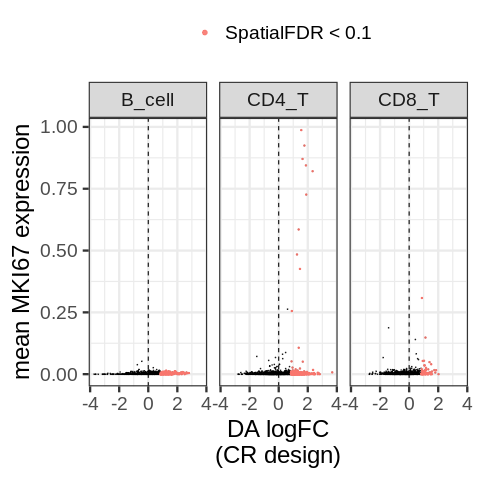

In [96]:
%%R 
nhood_df %>%
filter(nhood_annotation %in% c("CD4_T", "CD8_T", 'B_cell')) %>%
filter(design == 'CR') %>%
ggplot(aes(logFC, nhood_MKI67_expression)) +
    geom_point(size=0.2, alpha=0.7) +
    geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9) +
    facet_wrap(nhood_annotation~.) +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    geom_vline(xintercept=0, linetype=2) +
    xlab("DA logFC\n(CR design)") + ylab("mean MKI67 expression") +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'CR_MKI67VSlogFC_all_ggplot.png'), width=12, height=6) +
    ggsave(paste0(figdir, 'CR_MKI67VSlogFC_all_ggplot.pdf'), width=12, height=6)

In [246]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')

In [252]:
nhood_df_acr = adata.uns['nhood_adata'].obs.copy()
nhood_df_cr = adata_c.uns['nhood_adata'].obs.copy()
nhood_df_acr['design'] = "ACR"
nhood_df_cr['design'] = "CR"
nh_df = pd.concat([nhood_df_cr, nhood_df_acr])

In [253]:
%%R -i nh_df
head(nh_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                                            index_cell kth_distance
1 10_1038_s41591_021_01329_2-BGCV01_TGGGCGTGTCGCTTTC-1     1.565102
2 10_1038_s41591_021_01329_2-BGCV01_TAGTTGGGTATGCTTG-1     1.403343
3 10_1038_s41591_021_01329_2-BGCV01_ATGGGAGTCCCATTTA-1     1.355805
4 10_1038_s41591_021_01329_2-BGCV01_ACGCCGAGTGAAATCA-1     1.285266
5 10_1038_s41591_021_01329_2-BGCV01_GTCATTTTCGCTGATA-1     1.357077
6 10_1038_s41591_021_01329_2-BGCV01_GATTCAGAGGGTTCCC-1     1.265132
  nhood_annotation nhood_annotation_frac       logFC   logCPM           F
1          NK_16hi             0.4705882 -1.69037556 8.847513 23.53994743
2          NK_16hi             0.9225352  0.06809853 8.810621  0.03176861
3           CD4.CM             0.3903743 -0.51238337 8.963314  1.73598730
4          NK_16hi             0.9121951 -0.57317392 8.997533  2.49774128
5          NK_16hi             0.9757576 -0.41248521 8.889545  1.27260129
6          B_naive             0.8791946 -0.27122638 8.806710  0.51189149
      

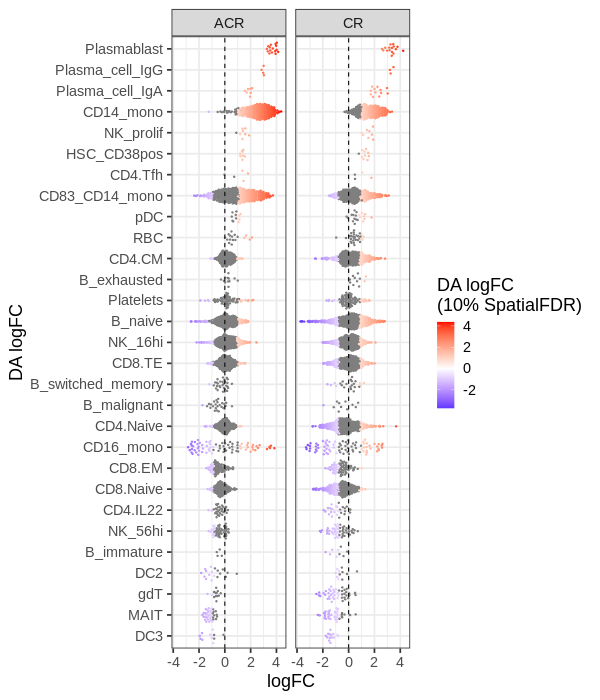

In [276]:
%%R -h 700 -w 600
nh_df %>%
filter(nhood_annotation_frac > 0.5) %>%
mutate(signif=ifelse(SpatialFDR < 0.1, logFC, NA)) %>%
group_by(nhood_annotation)%>%
mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
mutate(mean_lfc = mean(mean_lfc_val)) %>%
ungroup() %>%
arrange(mean_lfc) %>%
mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
ggplot(aes(nhood_annotation, logFC, color=signif)) + 
    ggbeeswarm::geom_quasirandom(size=0.5) +
        coord_flip() +
        facet_wrap(design~.) +
        scale_color_gradient2(high='red', mid='white', low='blue', name='DA logFC\n(10% SpatialFDR)') +
        theme_bw(base_size=18) +
        geom_hline(yintercept=0, linetype=2) +
        xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC') +
        ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width=10, height=12) +
        ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width=10, height=12)

### Precision-recall analysis

In [153]:
# scipy.stats.pearsonr(nhood_adata_c.obs['logFC'], nhood_adata_c.obs['nhood_IFN_signature'])
# scipy.stats.pearsonr(nhood_adata.obs['logFC'], nhood_adata.obs['nhood_IFN_signature'])
from sklearn.metrics import precision_recall_curve, auc

min_sign = 0.05
nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign

pr, rec, _ = precision_recall_curve(nhood_adata_c.obs['is_IFN_activated'], nhood_adata_c.obs['logFC'])
auprc_df_c = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df_c['AUPRC'] = auc(rec, pr)
auprc_df_c['design'] = 'PC'
auprc_df_c['thresh'] = nhood_adata_c.obs['is_IFN_activated'].sum()/nhood_adata_c.n_obs

pr, rec, _ = precision_recall_curve(nhood_adata.obs['is_IFN_activated'], nhood_adata.obs['logFC'])
auprc_df = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df['AUPRC'] = auc(rec, pr)
auprc_df['design'] = 'PAC'
auprc_df['thresh'] = nhood_adata.obs['is_IFN_activated'].sum()/nhood_adata.n_obs 

auprc_df = pd.concat([auprc_df, auprc_df_c])

In [116]:
%%R -i auprc_df
head(auprc_df)

  Precision    Recall     AUPRC design    thresh
1 0.2049663 1.0000000 0.6693779    PAC 0.2033828
2 0.2047990 0.9989733 0.6693779    PAC 0.2033828
3 0.2048421 0.9989733 0.6693779    PAC 0.2033828
4 0.2048852 0.9989733 0.6693779    PAC 0.2033828
5 0.2049284 0.9989733 0.6693779    PAC 0.2033828
6 0.2049716 0.9989733 0.6693779    PAC 0.2033828


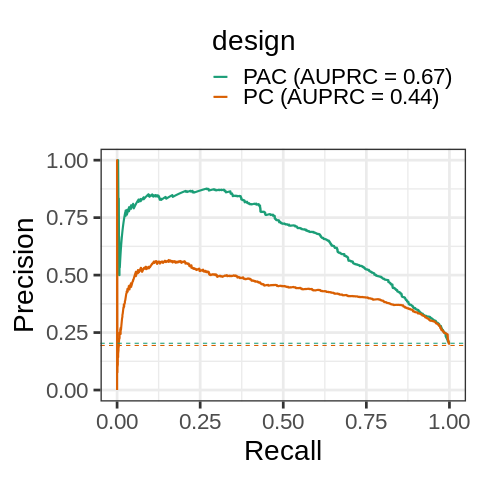

In [134]:
%%R
auprc_df %>%
mutate(design = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
ggplot(aes(Recall, Precision, group=design, color=design)) +
geom_line(size=1) +
geom_hline(linetype=2, aes(yintercept=thresh, color=design)) +
scale_color_brewer(palette='Dark2') +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=28) +
theme(legend.position='top', legend.justification='right') +
ggsave(paste0(figdir, 'PR_curves_IFN.png'), width=6, height=8) +
ggsave(paste0(figdir, 'PR_curves_IFN.pdf'), width=6, height=8)

In [136]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')

## Compare with _de novo_ integration including disease cases

Prepare ACR design design object (de novo integration) 

In [22]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata_p = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design._PAC.h5ad')

## Add dataset specific obs
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_p.obs_names]]
new_obs.index = adata_p.obs_names
adata_p.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_p.obs.columns)], adata_p.obs], 1)


/tmp/ipykernel_51793/1119636803.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  adata_p.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_p.obs.columns)], adata_p.obs], 1)


Prepare CR design design object (de novo integration) 

In [23]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata_pc = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design._PC.h5ad')


## Add dataset specific obs
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_pc.obs_names]]
new_obs.index = adata_pc.obs_names
adata_pc.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_pc.obs.columns)], adata_pc.obs], 1)


/tmp/ipykernel_51793/1686195707.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  adata_pc.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_pc.obs.columns)], adata_pc.obs], 1)


Run differential analysis

In [24]:
run_milo(adata_p, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
run_milo(adata_pc, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-pac

In [25]:
adata_p.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_p.obs['author_cell_type']]
adata_pc.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_pc.obs['author_cell_type']]

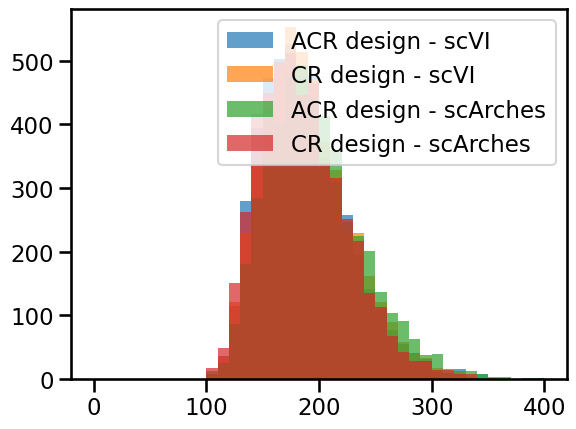

In [29]:
binwidth=10
plt.hist(np.array(adata_p.obsm['nhoods'].sum(0)).flatten(),
        bins=np.arange(0, 400 + binwidth, binwidth), 
         alpha=0.7, label='ACR design - scVI'
        );
plt.hist(np.array(adata_pc.obsm['nhoods'].sum(0)).flatten(),
                 bins=np.arange(0, 400 + binwidth, binwidth), 
         alpha=0.7, label='CR design - scVI'
        );
plt.hist(np.array(adata.obsm['nhoods'].sum(0)).flatten(),
        bins=np.arange(0, 400 + binwidth, binwidth), 
         alpha=0.7, label='ACR design - scArches'
        );
plt.hist(np.array(adata_c.obsm['nhoods'].sum(0)).flatten(),
                 bins=np.arange(0, 400 + binwidth, binwidth), 
         alpha=0.7, label='CR design - scArches'
        );
plt.legend()

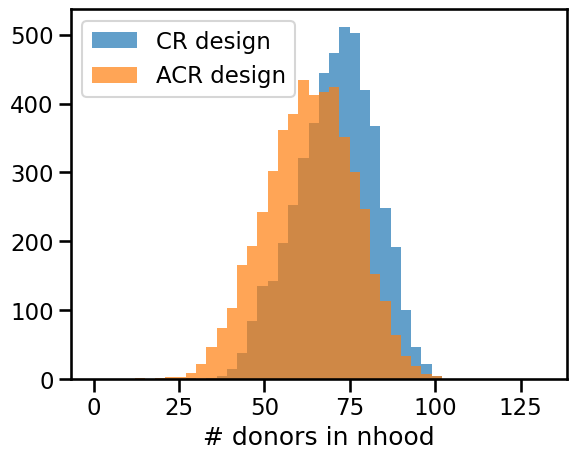

In [27]:
binwidth=3
nhood_adata = adata_pc.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='CR design'
        );

nhood_adata = adata_p.uns['nhood_adata']
milo_mat = nhood_adata.X.copy()
milo_mat[milo_mat.nonzero()] = 1
plt.hist(np.array(milo_mat.sum(1)).flatten(),
        bins=np.arange(0, milo_mat.shape[1] + binwidth, binwidth), 
         alpha=0.7, label='ACR design'
        );
plt.legend()
plt.xlabel('# donors in nhood');
plt.show()

In [184]:
milopy.utils.annotate_nhoods(adata_p, 'author_cell_type_broad')
adata_p.obs['IFN_signature'] = adata.obs.loc[adata_p.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_p, "IFN_signature")
nhood_adata_p = adata_p.uns['nhood_adata'].copy()

milopy.utils.annotate_nhoods(adata_pc, 'author_cell_type_broad')
adata_pc.obs['IFN_signature'] = adata.obs.loc[adata_pc.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_pc, "IFN_signature")
nhood_adata_pc = adata_pc.uns['nhood_adata'].copy()

In [185]:
from sklearn.metrics import precision_recall_curve, auc

min_sign = 0.05
nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign
nhood_adata_p.obs['is_IFN_activated'] = nhood_adata_p.obs['nhood_IFN_signature'] > min_sign
nhood_adata_pc.obs['is_IFN_activated'] = nhood_adata_pc.obs['nhood_IFN_signature'] > min_sign

pr, rec, _ = precision_recall_curve(nhood_adata_p.obs['is_IFN_activated'], nhood_adata_p.obs['logFC'])
auprc_df_p = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df_p['AUPRC'] = auc(rec, pr)
auprc_df_p['design'] = 'PAC joint'
auprc_df_p['thresh'] = nhood_adata_p.obs['is_IFN_activated'].sum()/nhood_adata_p.n_obs

pr, rec, _ = precision_recall_curve(nhood_adata_pc.obs['is_IFN_activated'], nhood_adata_pc.obs['logFC'])
auprc_df_pc = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df_pc['AUPRC'] = auc(rec, pr)
auprc_df_pc['design'] = 'PC joint'
auprc_df_pc['thresh'] = nhood_adata_pc.obs['is_IFN_activated'].sum()/nhood_adata_pc.n_obs

pr, rec, _ = precision_recall_curve(nhood_adata_c.obs['is_IFN_activated'], nhood_adata_c.obs['logFC'])
auprc_df_c = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df_c['AUPRC'] = auc(rec, pr)
auprc_df_c['design'] = 'PC'
auprc_df_c['thresh'] = nhood_adata_c.obs['is_IFN_activated'].sum()/nhood_adata_c.n_obs

pr, rec, _ = precision_recall_curve(nhood_adata.obs['is_IFN_activated'], nhood_adata.obs['logFC'])
auprc_df = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df['AUPRC'] = auc(rec, pr)
auprc_df['design'] = 'PAC'
auprc_df['thresh'] = nhood_adata.obs['is_IFN_activated'].sum()/nhood_adata.n_obs 

auprc_df = pd.concat([auprc_df, auprc_df_c, auprc_df_p, auprc_df_pc])

In [13]:
%%R -i auprc_df
head(auprc_df)

UsageError: Cell magic `%%R` not found.


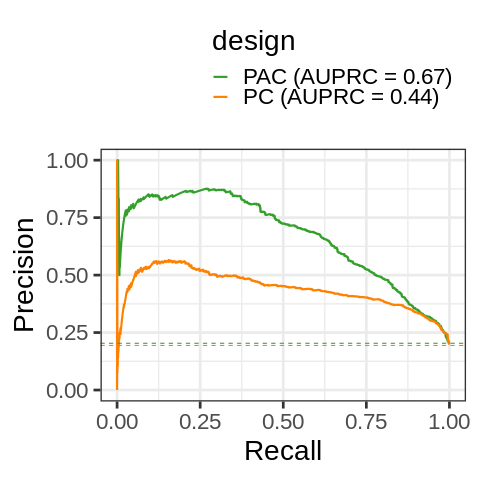

In [187]:
%%R
design_pal <- RColorBrewer::brewer.pal("Paired", n=10)[c(4,3,8,7)]

auprc_df %>%
    mutate(design = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
    ggplot(aes(Recall, Precision, group=design, color=design)) +
    geom_line(size=1) +
    geom_hline(linetype=2, aes(yintercept=thresh, color=design)) +
    scale_color_manual(values=design_pal) +
    guides(color=guide_legend(ncol=1, title.position='top')) +
    theme_bw(base_size=28) +
    theme(legend.position='top', legend.justification='right') +
    ggsave(paste0(figdir, 'PR_curves_IFN_joint.png'), width=6, height=8) +
    ggsave(paste0(figdir, 'PR_curves_IFN_joint.pdf'), width=6, height=8)
    
auprc_df %>%
    mutate(design = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
    filter(!str_detect(design, 'joint')) %>%
    ggplot(aes(Recall, Precision, group=design, color=design)) +
    geom_line(size=1) +
    geom_hline(linetype=2, aes(yintercept=thresh, color=design)) +
    scale_color_manual(values=design_pal[c(1,3)]) +
    guides(color=guide_legend(ncol=1, title.position='top')) +
    theme_bw(base_size=28) +
    theme(legend.position='top', legend.justification='right') +
    ggsave(paste0(figdir, 'PR_curves_IFN.png'), width=6, height=8) +
    ggsave(paste0(figdir, 'PR_curves_IFN.pdf'), width=6, height=8)

## Save outputs

In [23]:
milopy.utils.write_milo_adata(adata, filepath=data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')

In [21]:
milopy.utils.write_milo_adata(adata_c, filepath=data_dir + 'PBMC_COVID.subsample500cells.design.query_P_refC.post_milo.h5ad')

## Pathological subtypes analysis - check IFN-low enriched states

In [13]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata = milopy.utils.read_milo_adata(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
anno_labels = adata.obs['author_cell_type'].unique()
anno_groups = {}
anno_groups['B_cell'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('B_')]
anno_groups['HSPC'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('HSC_')]
anno_groups['CD14_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD14_mono' in x]
anno_groups['CD16_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD16_mono' in x]
anno_groups['CD4_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD4.")]
anno_groups['CD8_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD8.")]
anno_groups['ILC'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("ILC")]
anno_groups['Plasma_cell'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("Plasma_cell")]

for x in anno_labels: 
    if x not in sum(anno_groups.values(), []):
        anno_groups[x] = [x]

anno_labels_dict = {x:k for k,v in anno_groups.items() for x in v}
adata.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata.obs['author_cell_type']]
milopy.utils.annotate_nhoods(adata, anno_col='author_cell_type_broad')

In [15]:
milo_res = adata.uns['nhood_adata'].obs.copy()

In [16]:
mono_res=milo_res[milo_res.nhood_annotation.isin(['CD14_mono', 'CD16_mono'])]

In [49]:
%%R -i mono_res
head(mono_res)

                                          index_cell kth_distance
7  10_1038_s41591_021_01329_2-S11_CTACATTGTCATCGGC-1    0.8488339
9  10_1038_s41591_021_01329_2-S11_CGTCACTGTCATACTG-1    0.7458368
16 10_1038_s41591_021_01329_2-S11_GACTAACCACTTACGA-1    0.8635404
21 10_1038_s41591_021_01329_2-S11_TGGGCGTTCAGTCAGT-1    0.7818075
23 10_1038_s41591_021_01329_2-S11_GTCTCGTAGTTTCCTT-1    0.9215596
25 10_1038_s41591_021_01329_2-S11_AGTGAGGAGGCTCAGA-1    1.1544625
   nhood_annotation nhood_annotation_frac       logFC   logCPM            F
7         CD14_mono             0.9772727 -0.78879948 8.859451  3.969117777
9         CD14_mono             0.9802955  0.49986790 8.967559  1.254272107
16        CD14_mono             1.0000000  0.03823584 8.730108  0.008553883
21        CD14_mono             0.8720379  1.26915138 9.003519  6.943061569
23        CD14_mono             0.9800000  2.82206506 8.790340 28.341172501
25        CD14_mono             0.9935898 -0.68602556 8.801006  3.122999346
      

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


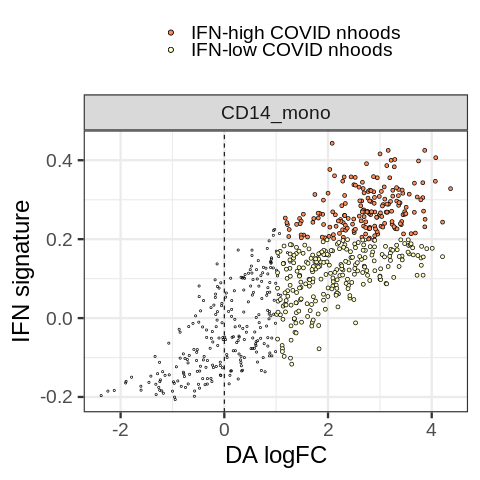

In [199]:
%%R
mono_res %>%
    filter(nhood_annotation == 'CD14_mono') %>%
    ggplot(aes(logFC, nhood_IFN_signature)) +
    geom_point(size=0.7, shape=21) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature > 0.2), 
               shape=21,
               aes(fill='IFN-high COVID nhoods')) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature < 0.2), 
               shape=21,
               aes(fill='IFN-low COVID nhoods')) +
    facet_wrap(nhood_annotation~.) +
    guides(fill=guide_legend(title='', override.aes = list(size=2), ncol=1)) +
    theme_bw(base_size=24) +
    scale_fill_brewer(palette='Spectral', name='') +
    geom_vline(xintercept=0, linetype=2) +
#     geom_hline(yintercept=0, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'groups_CD14_monos.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'groups_CD14_monos.pdf'), height=7, width=7)
    

In [64]:
import diff2atlas

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    sdata.X = sdata.layers['counts'].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    
    pbulk_sdata.var = adata.var.copy() 
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'in_nhoods_{ctrl_group}', 
                           contrast = f'nhood_groupsin_nhoods_{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

In [18]:
## Select nhoods of interest
cd14_mono_res = mono_res[mono_res.nhood_annotation == 'CD14_mono']
low_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature < 0.2)]
high_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature > 0.2)]

In [19]:
other_monos_nhoods = cd14_mono_res.index[~((cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0))]

In [20]:
## Mark nhood groups
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[low_ifn_monos_nhoods, 'nhood_groups'] = 'low_ifn_enr'
nhood_adata.obs.loc[high_ifn_monos_nhoods, 'nhood_groups'] = 'high_ifn_enr'
nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other_CD14_monos'
adata.uns['nhood_adata'] = nhood_adata.copy()

In [65]:
## Run DE testing
DE_monos_ifn = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'] == 'CD14_mono' ], 
    test_group='low_ifn_enr', 
    ctrl_group='high_ifn_enr', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )


/nfs/team205/ed6/bin/diff2atlas/diff2atlas/utils.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['in_nhoods'] = in_nhoods
/tmp/ipykernel_10319/3522525962.py:110: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_10319/3522525962.py:67: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


In [66]:
DE_monos_ifn

pval      adj_pval  f_statistic  df1         df2       lfc  \
gene_name                                                                       
IFI27      4.855253e-01  7.758508e-01     0.487977    1  233.831244 -0.338966   
IFITM1     1.510698e-02  1.146512e-01     5.992048    1  233.831244 -0.870994   
IFITM3     1.583460e-02  1.175652e-01     5.906960    1  233.831244 -0.612019   
IFI30      1.016861e-19  3.170572e-16    99.280062    1  233.831244 -0.777538   
IFI6       1.570185e-01  4.739434e-01     2.015630    1  233.831244 -0.353517   
...                 ...           ...          ...  ...         ...       ...   
ARMCX6     3.398490e-01  6.691818e-01     0.914735    1  233.831244 -0.239128   
AGAP9      4.289123e-02  2.254707e-01     4.144752    1  233.831244  1.184103   
C12orf65   5.691454e-02  2.672583e-01     3.661205    1  233.831244 -0.942446   
CRELD2     4.794033e-01  7.727975e-01     0.501829    1  233.831244 -0.133901   
EIF4A3     7.207215e-01  8.935227e-01     0.128111    1  233.831244 -0.059521   

          gene_name  
gene_name            
IFI27         IFI27  
IFITM1       IFITM1  
IFITM3       IFITM3  
IFI30         IFI30  
IFI6           IFI6  
...             ...  
ARMCX6       ARMCX6  
AGAP9         AGAP9  
C12orf65   C12orf65  
CRELD2       CRELD2  
EIF4A3       EIF4A3  

[6236 rows x 7 columns]

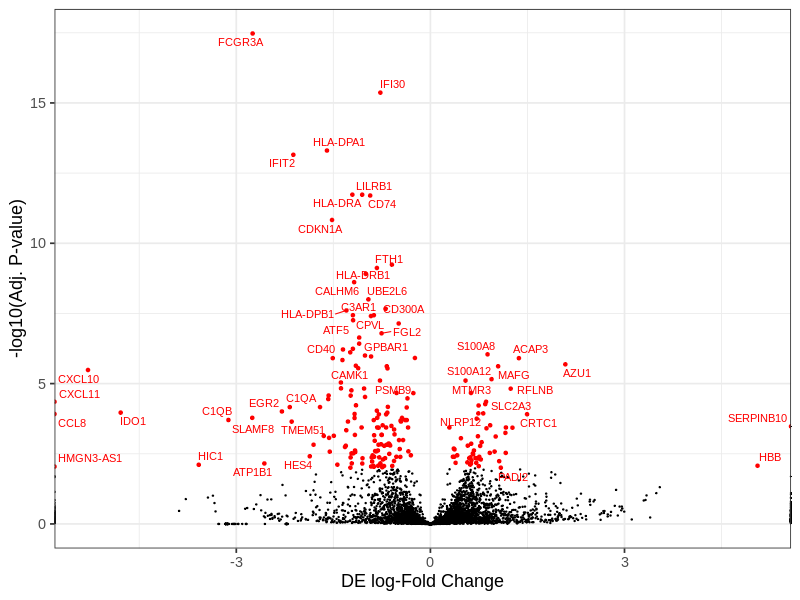

In [176]:
%%R -i DE_monos_ifn -w 800 -h 600 -i figdir
max_lfc = 15
DE_monos_ifn$lfc <- ifelse(abs(DE_monos_ifn$lfc) > max_lfc, sign(DE_monos_ifn$lfc) * Inf, DE_monos_ifn$lfc)
DE_monos_ifn %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') +
    ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

In [71]:
data_dir + "CD14_mono.DE_results.csv"

'/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/CD14_mono.DE_results.csv'

In [70]:
## Save for supplementary
DE_monos_ifn.to_csv(data_dir + "CD14_mono.DE_results.csv")

In [20]:
def assign_cells_2_nhood_group(
    adata, 
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    ):
    '''
    
    '''
    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

In [54]:
assign_cells_2_nhood_group(adata)

/tmp/ipykernel_21347/2242147816.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan


In [55]:
groups = adata.uns['nhood_adata'].obs['nhood_groups'].dropna().unique()
min_n_nhoods = 3
adata.obs['nhood_groups'] = np.nan
adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
## Keep only if cell is in at least min_n_nhoods nhoods of the same group
adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 


/tmp/ipykernel_21347/879146469.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan


In [183]:
plt.rcParams['figure.figsize'] = [10, 10]
# n_cells_sev = adata.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
# n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
n_cells_sev = adata.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()

order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
# sns.boxplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', order=order_severity)
# sns.stripplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', 
#               color='black', position='dodge',
#               order=order_severity)
# n_cells_sev = n_cells_sev[~n_cells_sev.Days_from_onset.isin(['Healthy', 'LPS', 'Not_known', 'nan'])]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


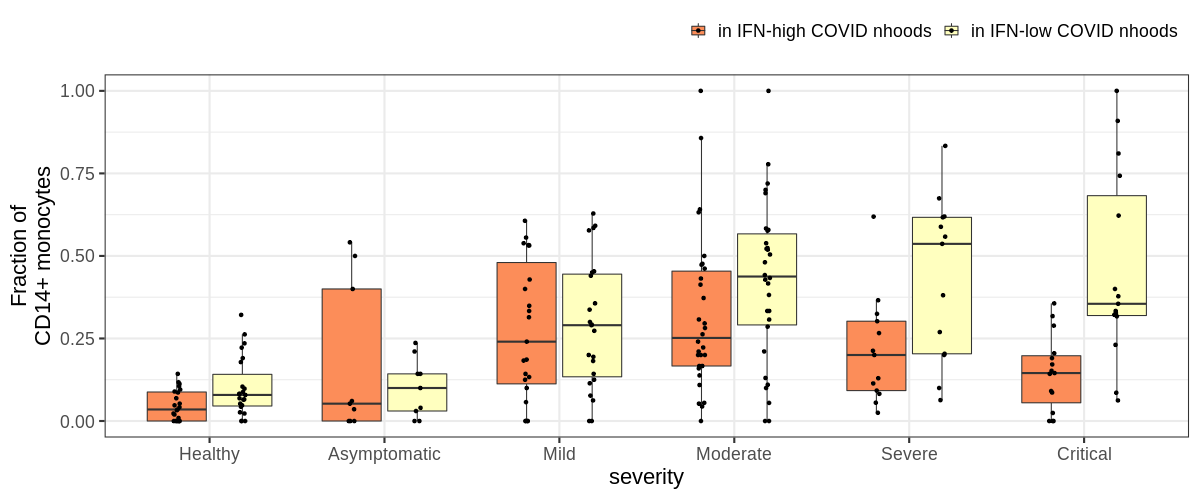

In [185]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500
n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    ggplot(aes(severity, frac_cells, fill = nhood_groups)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(position=position_jitterdodge(jitter.width=0.1)) +
#     facet_wrap(nhood_groups~.) +
#     scale_y_log10() +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('Fraction of\nCD14+ monocytes') +
    theme_bw(base_size=22) +
    theme(legend.position='top', legend.justification=c(1,1)) +
    ggsave(paste0(figdir, 'CD14_monos_severity.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'CD14_monos_severity.pdf'), height=7, width=10) 

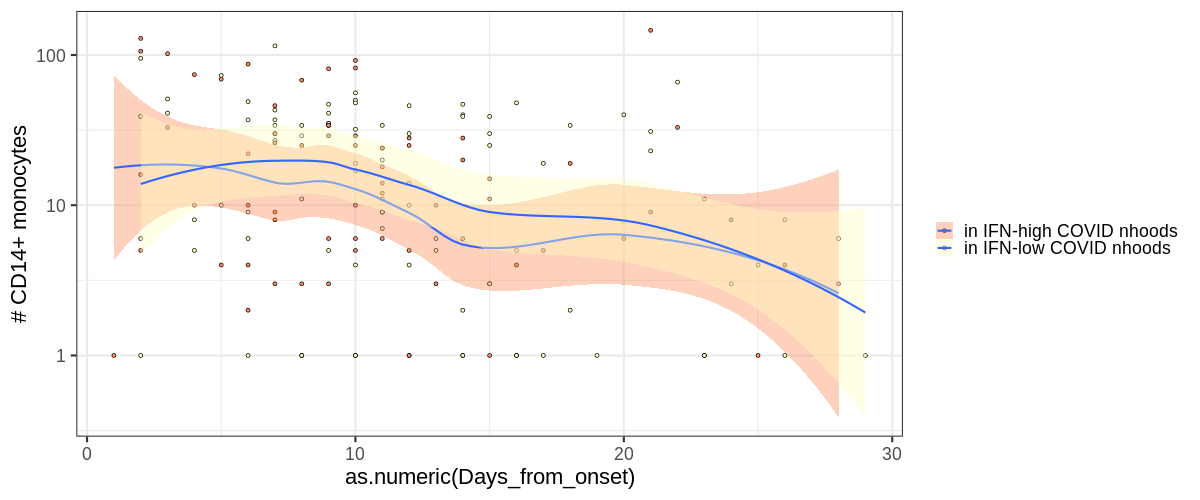

In [134]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500
n_cells_sev %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
#     filter(Days_from_onset != 'Not_known') %>%
    ggplot(aes(as.numeric(Days_from_onset), n_cells, fill = nhood_groups)) +
#     geom_boxplot(outlier.alpha=0) +
    geom_point(shape=21) +
#     facet_wrap(nhood_groups~.) +
    scale_y_log10() +
    geom_smooth() +
    scale_color_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('# CD14+ monocytes') +
    theme_bw(base_size=22)

### Compare to CR design

In [146]:
milo_res_c = adata_c.uns['nhood_adata'].obs.copy()

In [149]:
mono_res_c = milo_res_c[milo_res_c.nhood_annotation.isin(['CD14_mono', 'CD16_mono'])]

In [ ]:
%%R -i mono_res_c
head(mono_res_c)

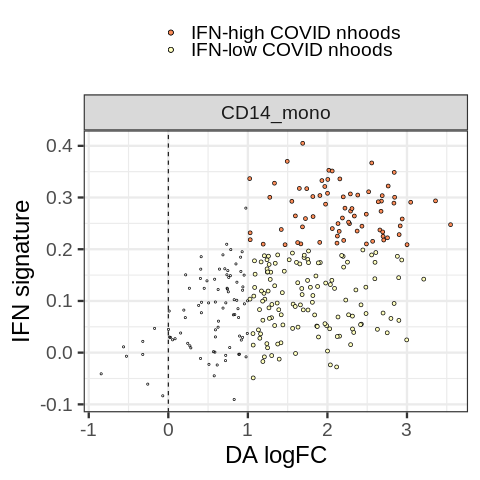

In [151]:
%%R
mono_res_c %>%
    filter(nhood_annotation == 'CD14_mono') %>%
    ggplot(aes(logFC, nhood_IFN_signature)) +
    geom_point(size=0.7, shape=21) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature > 0.2), 
               shape=21,
               aes(fill='IFN-high COVID nhoods')) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature < 0.2), 
               shape=21,
               aes(fill='IFN-low COVID nhoods')) +
    facet_wrap(nhood_annotation~.) +
    guides(fill=guide_legend(title='', override.aes = list(size=2), ncol=1)) +
    theme_bw(base_size=24) +
    scale_fill_brewer(palette='Spectral', name='') +
    geom_vline(xintercept=0, linetype=2) +
#     geom_hline(yintercept=0, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'groups_CD14_monos_CR.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'groups_CD14_monos_CR.pdf'), height=7, width=7)
    

In [21]:
## Select nhoods of interest
cd14_mono_res = mono_res_c[mono_res_c.nhood_annotation == 'CD14_mono']
low_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature < 0.2)]
high_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature > 0.2)]

In [22]:
other_monos_nhoods = cd14_mono_res.index[~((cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0))]

In [23]:
## Mark nhood groups
nhood_adata = adata_c.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[low_ifn_monos_nhoods, 'nhood_groups'] = 'low_ifn_enr'
nhood_adata.obs.loc[high_ifn_monos_nhoods, 'nhood_groups'] = 'high_ifn_enr'
nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other_CD14_monos'
adata_c.uns['nhood_adata'] = nhood_adata.copy()

In [32]:
adata_c.layers['counts'] = adata_c.X.copy()

In [58]:
sc.pp.normalize_per_cell(adata_c)
sc.pp.log1p(adata_c)

In [ ]:
# ## Run DE testing
# DE_monos_ifn = find_nhood_group_markers(
#     adata_c[adata_c.obs['author_cell_type'] == 'CD14_mono' ], 
#     test_group='low_ifn_enr', 
#     ctrl_group='high_ifn_enr', 
#     confounders_obs=['Site'],
#     n_hvgs = 7500
#     )


# %%R -i DE_monos_ifn -w 800 -h 600 -i figdir
# max_lfc = 15
# DE_monos_ifn$lfc <- ifelse(abs(DE_monos_ifn$lfc) > max_lfc, sign(DE_monos_ifn$lfc) * Inf, DE_monos_ifn$lfc)
# DE_monos_ifn %>%
# #     filter(contrast == 'mild_enr-other') %>%
#     mutate(signif = adj_pval < 0.01) %>%
#     mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
#     ggplot(aes(lfc, -log10(adj_pval))) + 
#     geom_point(size=0.5) +
#     geom_point(data=. %>% filter(signif), color='red') +
#     ggrepel::geom_text_repel(aes(label=label), color='red') +
#     theme_bw(base_size=18) +
#     xlab("DE log-Fold Change") +
#     ylab('-log10(Adj. P-value)') +
#     ggsave(paste0(figdir, 'volcano_CD14_monos_CR.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos_CR.pdf'), height=7, width=7) 

In [37]:
assign_cells_2_nhood_group(adata_c)

/tmp/ipykernel_21347/2242147816.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan


In [38]:
groups = adata_c.uns['nhood_adata'].obs['nhood_groups'].dropna().unique()
min_n_nhoods = 3
adata_c.obs['nhood_groups'] = np.nan
adata_c.obs['nhood_groups'] = adata_c.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
## Keep only if cell is in at least min_n_nhoods nhoods of the same group
adata_c.obs.loc[~(adata_c.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 


/tmp/ipykernel_21347/2976013588.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata_c.obs.loc[~(adata_c.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan


In [170]:
adata_c.obs['nhood_groups']

10_1038_s41591_021_01329_2-BGCV01_GACCTGGGTAAGCACG-1       NaN
10_1038_s41591_021_01329_2-BGCV01_CAGCAGCAGCGTCTAT-1       NaN
10_1038_s41591_021_01329_2-BGCV01_CACTCCAGTCCGTCAG-1       NaN
10_1038_s41591_021_01329_2-BGCV01_CGGCTAGCATACTCTT-1       NaN
10_1038_s41591_021_01329_2-BGCV01_GGGCACTAGCTCCTTC-1       NaN
                                                          ... 
10_1038_s41591_021_01329_2-ATGTGTGCACCAGATT-newcastle59    NaN
10_1038_s41591_021_01329_2-TGAGCATAGGCAGGTT-newcastle59    NaN
10_1038_s41591_021_01329_2-TCGCGAGAGCTAGCCC-newcastle59    NaN
10_1038_s41591_021_01329_2-TATGCCCTCACCTCGT-newcastle59    NaN
10_1038_s41591_021_01329_2-GCACATAGTCAATGTC-newcastle59    NaN
Name: nhood_groups, Length: 62509, dtype: category
Categories (3, object): ['in_nhoods_high_ifn_enr', 'in_nhoods_low_ifn_enr', 'in_nhoods_other_CD14_monos']

In [179]:
n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()

nhood_groups Status_on_day_collection_summary  \
0         in_nhoods_high_ifn_enr                     Asymptomatic   
1         in_nhoods_high_ifn_enr                     Asymptomatic   
2         in_nhoods_high_ifn_enr                     Asymptomatic   
3         in_nhoods_high_ifn_enr                     Asymptomatic   
4         in_nhoods_high_ifn_enr                     Asymptomatic   
...                          ...                              ...   
2851  in_nhoods_other_CD14_monos                           Severe   
2852  in_nhoods_other_CD14_monos                           Severe   
2853  in_nhoods_other_CD14_monos                           Severe   
2854  in_nhoods_other_CD14_monos                           Severe   
2855  in_nhoods_other_CD14_monos                           Severe   

           donor_id  n_cells  
0               AP1        0  
1               AP2        0  
2               AP3        0  
3               AP4        0  
4               AP5        0  
...             ...      ...  
2851  newcastle21v2        0  
2852    newcastle49        9  
2853    newcastle59        0  
2854    newcastle65        0  
2855    newcastle74        0  

[2856 rows x 4 columns]

In [180]:
plt.rcParams['figure.figsize'] = [10, 10]
# n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()
order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
# sns.boxplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', order=order_severity)
# sns.stripplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', 
#               color='black', position='dodge',
#               order=order_severity)
# n_cells_sev = n_cells_sev[~n_cells_sev.Days_from_onset.isin(['Healthy', 'LPS', 'Not_known', 'nan'])]


nhood_groups Status_on_day_collection_summary  \
0         in_nhoods_high_ifn_enr                     Asymptomatic   
1         in_nhoods_high_ifn_enr                     Asymptomatic   
2         in_nhoods_high_ifn_enr                     Asymptomatic   
3         in_nhoods_high_ifn_enr                     Asymptomatic   
4         in_nhoods_high_ifn_enr                     Asymptomatic   
...                          ...                              ...   
2018  in_nhoods_other_CD14_monos                     Asymptomatic   
2019  in_nhoods_other_CD14_monos                     Asymptomatic   
2020  in_nhoods_other_CD14_monos                     Asymptomatic   
2021  in_nhoods_other_CD14_monos                     Asymptomatic   
2022  in_nhoods_other_CD14_monos                     Asymptomatic   

           donor_id  n_cells  
0               AP1        0  
1               AP2        0  
2               AP3        0  
3               AP4        0  
4               AP5        0  
...             ...      ...  
2018  newcastle21v2        0  
2019    newcastle49        0  
2020    newcastle59        0  
2021    newcastle65        0  
2022    newcastle74        0  

[357 rows x 4 columns]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


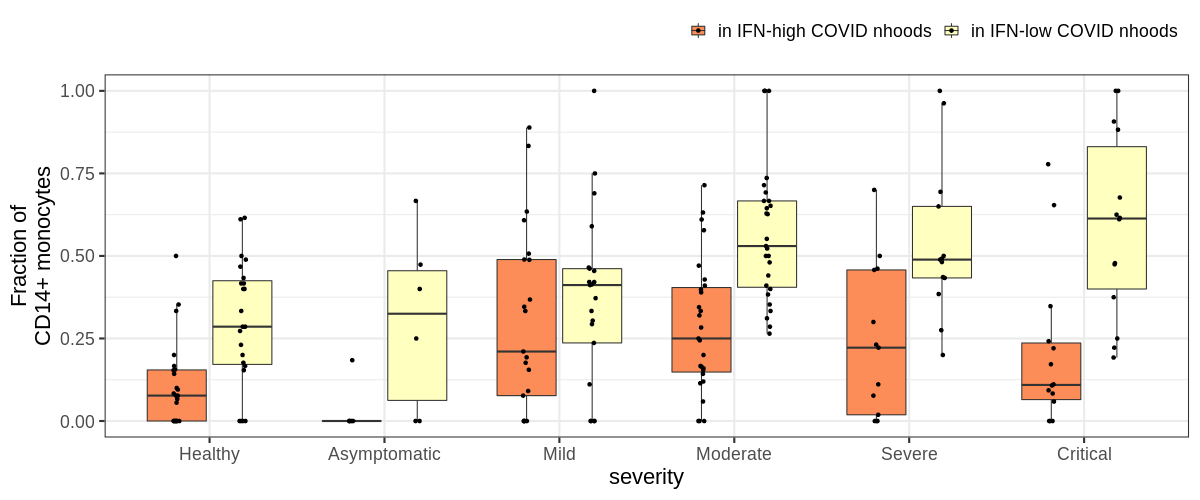

In [182]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500 -i figdir
n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
#     filter(severity == 'Asymptomatic') %>%
#     select(nhood_groups, frac_cells, donor_id)
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    ggplot(aes(severity, frac_cells, fill = nhood_groups)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(position=position_jitterdodge(jitter.width=0.1)) +
#     facet_wrap(nhood_groups~.) +
#     scale_y_log10() +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('Fraction of\nCD14+ monocytes') +
    theme_bw(base_size=22) +
    theme(legend.position='top', legend.justification=c(1,1)) +
    ggsave(paste0(figdir, 'CD14_monos_severity_CR.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'CD14_monos_severity_CR.pdf'), height=7, width=10) 

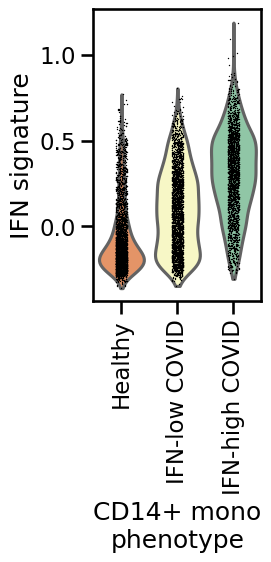

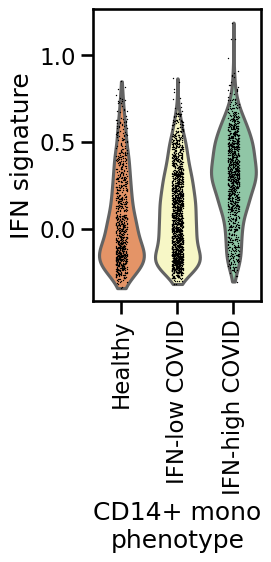

In [152]:
mono_phenotype = {
    'in_nhoods_low_ifn_enr':'IFN-low COVID',
    'in_nhoods_high_ifn_enr':'IFN-high COVID',
    'in_nhoods_other_CD14_monos':'Healthy',
    }

with rc_context({'figure.figsize':[3,4]}):
    adata.obs['mono_phenotype'] = [mono_phenotype[x] if x in mono_phenotype.keys() else np.nan for x in adata.obs['nhood_groups']]
    adata.obs['mono_phenotype'] = adata.obs['mono_phenotype'].astype('category').cat.reorder_categories(['Healthy','IFN-low COVID', 'IFN-high COVID'])
    sc.pl.violin(adata, 'IFN_signature', groupby='mono_phenotype', palette='Spectral', rotation=90, 
                 xlabel='CD14+ mono\nphenotype', ylabel='IFN signature', save='mono_phenotypes_ACR.png');
    
with rc_context({'figure.figsize':[3,4]}):
    adata_c.obs['mono_phenotype'] = [mono_phenotype[x] if x in mono_phenotype.keys() else np.nan for x in adata_c.obs['nhood_groups']]
    adata_c.obs['mono_phenotype'] = adata_c.obs['mono_phenotype'].astype('category').cat.reorder_categories(['Healthy','IFN-low COVID', 'IFN-high COVID'])
    sc.pl.violin(adata_c, 'IFN_signature', groupby='mono_phenotype', palette='Spectral', rotation=90, 
                 xlabel='CD14+ mono\nphenotype', ylabel='IFN signature', save='mono_phenotypes_CR.png');
# sc.pl.violin(adata, 'IFN_signature',groupby='nhood_groups')
# sc.pl.violin(adata_c, 'IFN_signature',groupby='nhood_groups')

## Compare designs on clustering

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [230]:
split_seed = 42
n_iters = 3
def label_transfer_classify(adata, n_iters = 10, split_seed=42):
    X = adata.obsm['X_scVI'].copy()
    y = adata.obs['author_cell_type'].copy()
    out_all_df = pd.DataFrame()
    for s in np.arange(split_seed, split_seed+n_iters):
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=s)

        clf = KNeighborsClassifier(
            n_neighbors=30,
            metric="euclidean"
            ).fit(X_train, y_train)
        class_out = classification_report(y_test, clf.predict(X_test), output_dict=True)
        out_df = pd.DataFrame.from_dict(class_out).T.reset_index()
        out_df['split_seed'] = s
        out_all_df = pd.concat([out_all_df, out_df])
    return(out_all_df)

In [231]:
clf_acr = label_transfer_classify(adata)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [232]:
clf_cr = label_transfer_classify(adata_c)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [233]:
clf_cr['design'] = 'CR'
clf_acr['design'] = 'ACR'
clf_results = pd.concat([clf_cr, clf_acr])

In [241]:
ct_counts = adata.obs['author_cell_type'].value_counts()
keep_cts = ct_counts[ct_counts > 100].index.astype('str')
keep_cts

Index(['NK_16hi', 'CD4.CM', 'CD4.Naive', 'B_naive', 'CD83_CD14_mono', 'CD8.TE',
       'CD8.Naive', 'CD14_mono', 'CD4.IL22', 'CD4.Tfh', 'CD8.EM', 'Platelets',
       'gdT', 'CD16_mono', 'MAIT', 'NK_56hi', 'B_switched_memory',
       'B_immature', 'RBC', 'B_malignant', 'B_non-switched_memory', 'NKT',
       'pDC', 'DC3', 'Plasma_cell_IgG', 'NK_prolif', 'B_exhausted',
       'Plasmablast', 'CD4.EM', 'Plasma_cell_IgA', 'DC2', 'C1_CD16_mono',
       'HSC_CD38pos', 'CD8.Prolif', 'Plasma_cell_IgM'],
      dtype='object')

In [242]:
mean_p_acr = clf_acr[['index','f1-score']].groupby('index').median()
mean_p_acr.columns = ['precision_ACR']
mean_p_cr = clf_cr[['index','f1-score']].groupby('index').median()
mean_p_cr.columns = ['precision_CR']
p_mean = pd.concat([mean_p_cr, mean_p_acr],1 )
p_delta = p_mean['precision_ACR'] - p_mean['precision_CR']
sorted_ixs = p_delta.sort_values().index

/tmp/ipykernel_4395/1023192447.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  p_mean = pd.concat([mean_p_cr, mean_p_acr],1 )


In [243]:
clf_results['anno_group'] = [anno_labels_dict[x] if x in anno_labels_dict.keys() else np.nan for x in clf_results['index']]

In [244]:
%%R -i clf_results -i keep_cts -i sorted_ixs
head(clf_results)

                  index precision    recall  f1-score support split_seed design
1                  ASDC 0.0000000 0.0000000 0.0000000       3         42     CR
2           B_exhausted 0.6666667 0.5625000 0.6101695      64         42     CR
3            B_immature 0.7454545 0.3445378 0.4712644     119         42     CR
4           B_malignant 0.7000000 0.7241379 0.7118644      87         42     CR
5               B_naive 0.7961783 0.9319664 0.8587377    1073         42     CR
6 B_non-switched_memory 0.4285714 0.1785714 0.2521008      84         42     CR
  anno_group
1       ASDC
2     B_cell
3     B_cell
4     B_cell
5     B_cell
6     B_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


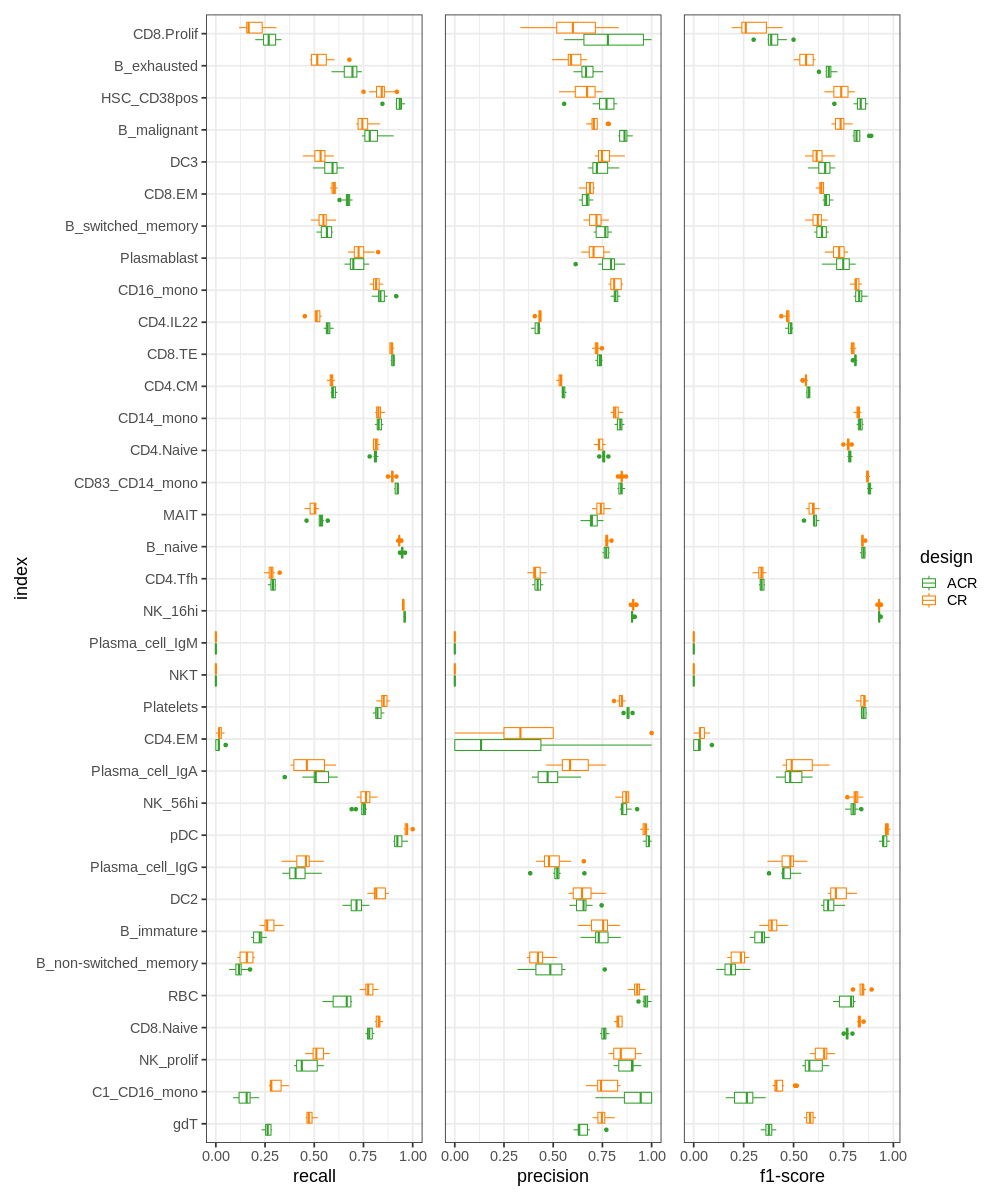

In [245]:
%%R -h 1200 -w 1000
pl_df <- clf_results %>%
    filter(index %in% unlist(keep_cts)) %>%
    group_by(index) %>%
    mutate(median_score = median(`precision`)) %>%
    ungroup() %>%
    filter(!index %in% c('accuracy', 'weighted avg', 'macro avg')) %>%
    arrange(median_score) %>%
    mutate(index = factor(index, levels=unlist(sorted_ixs))) %>%
    mutate(anno_group = ifelse(str_detect(anno_group, "NK"), "NK", anno_group)) %>%
    mutate(anno_group = ifelse( str_detect(anno_group, "ILC"), "ILC", anno_group)) %>%
    mutate(anno_group = ifelse(str_detect(anno_group, "DC"), "DC", anno_group)) %>%
    mutate(anno_group = ifelse(str_detect(anno_group, "mono"), "Monos", anno_group))
    
r_plot <- pl_df %>%
    ggplot(aes(index, `precision`, color=design)) +
    geom_boxplot() +
    coord_flip() +
    theme_bw(base_size=18) +
#     facet_grid(anno_group~., space='free', scales='free') +
    scale_color_manual(values=design_palette)
p_plot <- pl_df %>%
    ggplot(aes(index, `recall`, color=design)) +
    geom_boxplot() +
    coord_flip() +
#     facet_grid(anno_group~., space='free', scales='free') +
    theme_bw(base_size=18) +
    scale_color_manual(values=design_palette)
f_plot <- pl_df %>%
    ggplot(aes(index, `f1-score`, color=design)) +
    geom_boxplot() +
    coord_flip() +
    theme_bw(base_size=18) +
#     facet_grid(anno_group~., space='free', scales='free') +
    scale_color_manual(values=design_palette)
    
p_plot + (r_plot + remove_y_axis()) + (f_plot + remove_y_axis())+
plot_layout(guides='collect') 

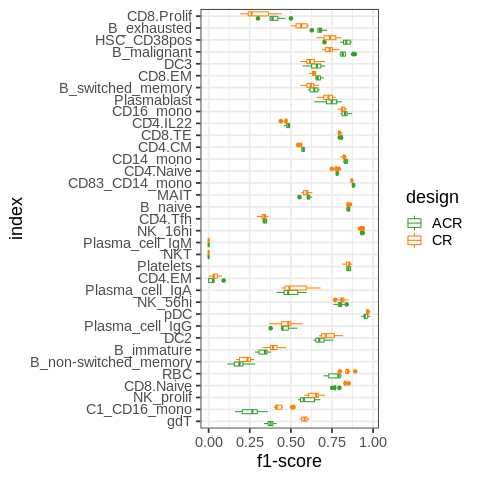

In [292]:
%%R
f_plot + 
    ggsave(paste0(figdir, 'KNN_classifier_labels_F1score.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'KNN_classifier_labels_F1score.pdf'), height=7, width=10) 

`summarise()` has grouped output by 'design'. You can override using the `.groups` argument.


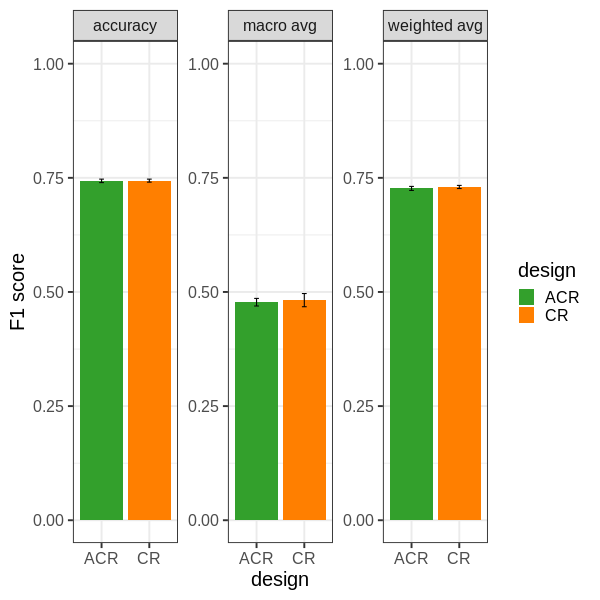

In [291]:
%%R -h 600 -w 600
clf_results %>%
    filter(index %in% c('accuracy', 'weighted avg', 'macro avg')) %>%
    group_by(design, index) %>%
    summarise(mean_score=mean(`f1-score`), sd_score=sd(`f1-score`)) %>%
    ggplot(aes(design, mean_score, fill=design)) +
    geom_col(position='dodge') +
    geom_errorbar(aes(ymin=mean_score - sd_score, ymax=mean_score + sd_score), position='dodge', width=0.1) +
    facet_wrap(index~., scales='free') +
    scale_fill_manual(values=design_palette) +
    ylim(0,1) +
    ylab("F1 score") +
    theme_bw(base_size=20) +
        ggsave(paste0(figdir, 'KNN_classifier_labels_mean.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'KNN_classifier_labels_mean.pdf'), height=7, width=10) 


---